In [61]:
import pandas as pd 
import numpy as np  
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import seaborn as sns 
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

movie_df = pd.read_csv('movie_master_dataset.csv', encoding = "ISO-8859-1")

top_genres = ['Action', 'Drama', 'Thriller', 'Comedy', 'Romance']
unpopular_genres = ['Documentary', 'Musical', 'History']

#Get the first 500 successful movies based on gross 
hg = movie_df.sort(['gross'], ascending = False)
hg = hg.reset_index(drop=True)
hg = hg.head(500)

directors = set(movie_df['director_name'].tolist()) 
director_hits = {} 
for director in directors: 
    df = hg[hg['director_name'] == director]
    director_hits[director] = len(df)

def get_movies(movie_df): 
    movies = [] 
    action = movie_df[movie_df['genres'].str.contains('Action')]
    movies.append(action)

    drama = movie_df[movie_df['genres'].str.contains('Drama')]
    movies.append(drama)

    thriller = movie_df[movie_df['genres'].str.contains('Thriller')]
    movies.append(thriller)
    
    comedy = movie_df[movie_df['genres'].str.contains('Comedy')]
    movies.append(comedy)
    
    romance = movie_df[movie_df['genres'].str.contains('Romance')]
    movies.append(romance)
    
    documentary = movie_df[movie_df['genres'].str.contains('Documentary')]
    movies.append(documentary)
    
    musical = movie_df[movie_df['genres'].str.contains('Musical')]
    movies.append(musical)
    
    history = movie_df[movie_df['genres'].str.contains('History')]
    movies.append(history)
    
    return movies

init_movies = get_movies(movie_df)

def get_hits(row): 
    return director_hits[row['director_name']] 

def get_title_length(row): 
    return len(row['movie_title'].split())
    
def get_actors_similarity(row): 
    actor_1 = row['actor_1_name']
    actor_2 = row['actor_2_name']
    actor_3 = row['actor_3_name']
    
    actor_1_vals = []
    actor_2_vals = [] 
    actor_3_vals = [] 
    for i in range(5): 
        ct_1 = init_movies[i][init_movies[i]['actor_1_name'] == actor_1]
        ct_2 = init_movies[i][init_movies[i]['actor_2_name'] == actor_2]
        ct_3 = init_movies[i][init_movies[i]['actor_3_name'] == actor_3]
        
        actor_1_vals.append(len(ct_1)) 
        actor_2_vals.append(len(ct_2)) 
        actor_3_vals.append(len(ct_3)) 
        
    d12, path = fastdtw(actor_1_vals, actor_2_vals, dist=euclidean) 
    d13, path = fastdtw(actor_1_vals, actor_3_vals, dist=euclidean)
    d23, path = fastdtw(actor_2_vals, actor_3_vals, dist=euclidean)
    avg = (d12 + d13 + d23)/3
    return avg 
    
    
#Retrieve hits for the director and format the movie duration 
movie_df['director_hits'] = movie_df.apply(lambda row: get_hits(row),axis=1)
movie_df['duration'] = movie_df['duration'].apply(lambda x: str(x))
movie_df['duration'] = movie_df['duration'].apply(lambda x: int(x[:3]) if x[0] == '1' else int(x[:2]))  
movie_df['title_len'] = movie_df.apply(lambda row: get_title_length(row), axis=1)  
movie_df['actors_similarity'] = movie_df.apply(lambda row: get_actors_similarity(row), axis=1)

movies = get_movies(movie_df)

def ols(data, feature1, feature2, feature3): 
    model = smf.ols(formula='gross ~ budget + duration + director_hits + actors_similarity', data=data).fit()
    model.summary()
    print(model.summary())

    fig = plt.figure(figsize=(12,10))
    fig = sm.graphics.plot_partregress_grid(model, fig=fig)

In [62]:
from scipy.stats import pearsonr

#Check for any correlation between the predictor variabales 
duration = movie_df['duration'].tolist() 
budget =  movie_df['budget'].tolist() 
director_hits = movie_df['director_hits'].tolist() 
title_len = movie_df['title_len'].tolist() 

duration_budget = pearsonr(duration, budget)
print('Correlation between duration and budget is ' + str(duration_budget[0])) 

duration_director_hits = pearsonr(duration, director_hits)
print("Correlation between duration and the director's number of successful movies is " + str(duration_director_hits[0])) 

duration_title_len = pearsonr(duration, title_len) 
print("Correlation between duration and the movie title's length is " + str(duration_title_len[0])) 

budget_director_hits = pearsonr(budget, director_hits)
print('Correlation between budget and the number of successful movie the director has made is ' + str(budget_director_hits[0]))

budget_title_len = pearsonr(budget, title_len)
print("Correlation between budget and the movie title's length is " + str(budget_title_len[0])) 

director_hits_title_len = pearsonr(budget, title_len)
print("Correlation between the director's number of successful movies and the movie title's length is " + str(director_hits_title_len[0])) 

Correlation between duration and budget is 0.0885455717556
Correlation between duration and the director's number of successful movies is 0.20813319372
Correlation between duration and the movie title's length is 0.000116934500448
Correlation between budget and the number of successful movie the director has made is 0.0471856007326
Correlation between budget and the movie title's length is 0.00661805321172
Correlation between the director's number of successful movies and the movie title's length is 0.00661805321172


Results for Action Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     13.70
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           6.37e-11
Time:                        20:36:43   Log-Likelihood:                -38318.
No. Observations:                1162   AIC:                         7.665e+04
Df Residuals:                    1157   BIC:                         7.667e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept   

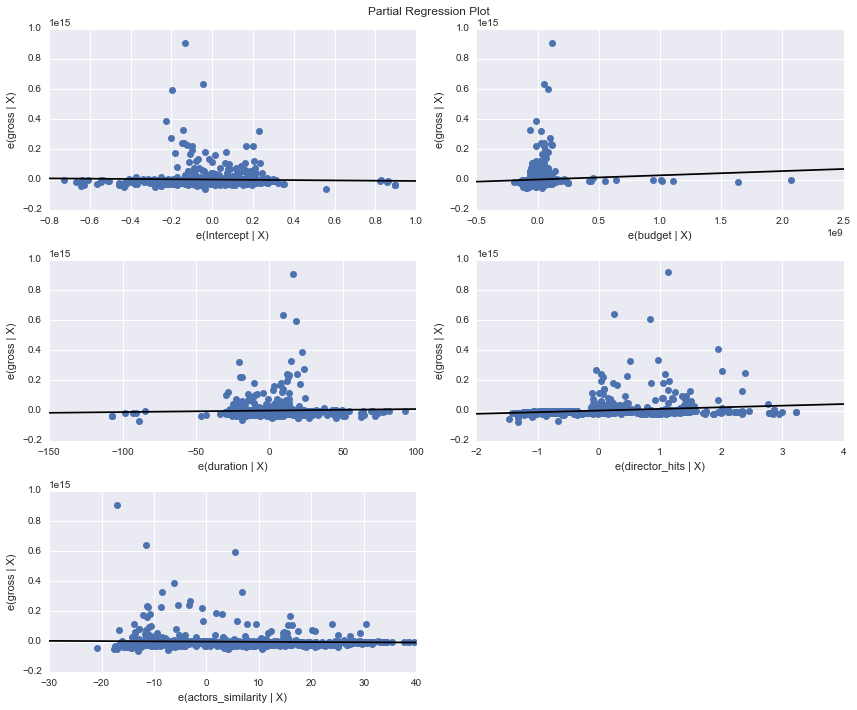

In [63]:
print('Results for ' + top_genres[0] + ' Movies')
ols(movies[0], 'duration', 'director_hits', 'budget') 

Results for Drama Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     35.69
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           5.13e-29
Time:                        20:37:38   Log-Likelihood:                -77939.
No. Observations:                2434   AIC:                         1.559e+05
Df Residuals:                    2429   BIC:                         1.559e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept    

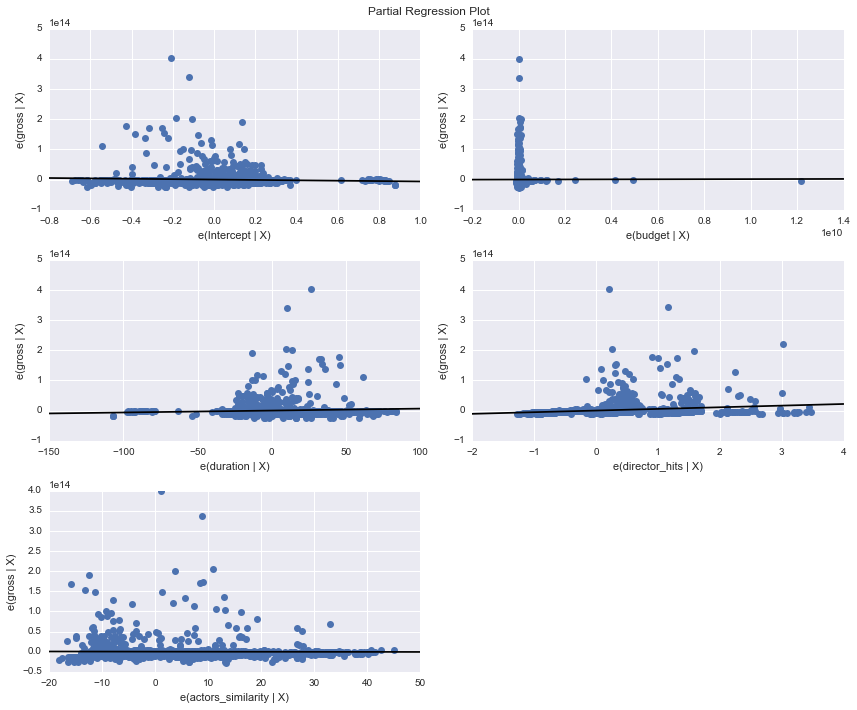

In [64]:
print('Results for ' + top_genres[1] + ' Movies')
ols(movies[1], 'duration', 'director_hits', 'budget') 

Results for Thriller Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     23.81
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           4.61e-19
Time:                        20:37:52   Log-Likelihood:                -44764.
No. Observations:                1376   AIC:                         8.954e+04
Df Residuals:                    1371   BIC:                         8.956e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept 

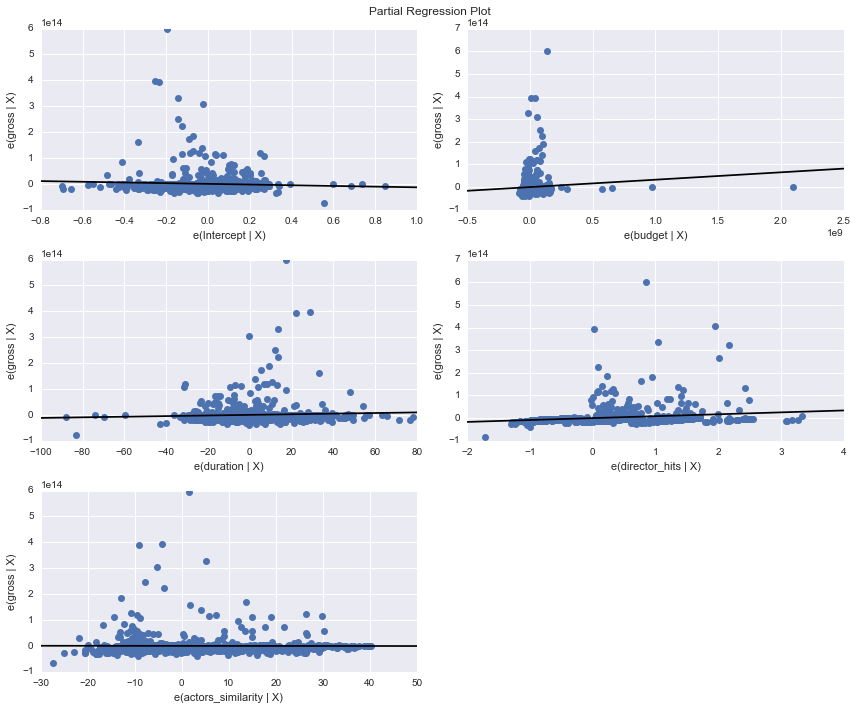

In [65]:
print('Results for ' + top_genres[2] + ' Movies')
ols(movies[2], 'duration', 'director_hits', 'budget') 

Results for Comedy Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     25.75
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           9.01e-21
Time:                        20:38:00   Log-Likelihood:                -57634.
No. Observations:                1782   AIC:                         1.153e+05
Df Residuals:                    1777   BIC:                         1.153e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept   

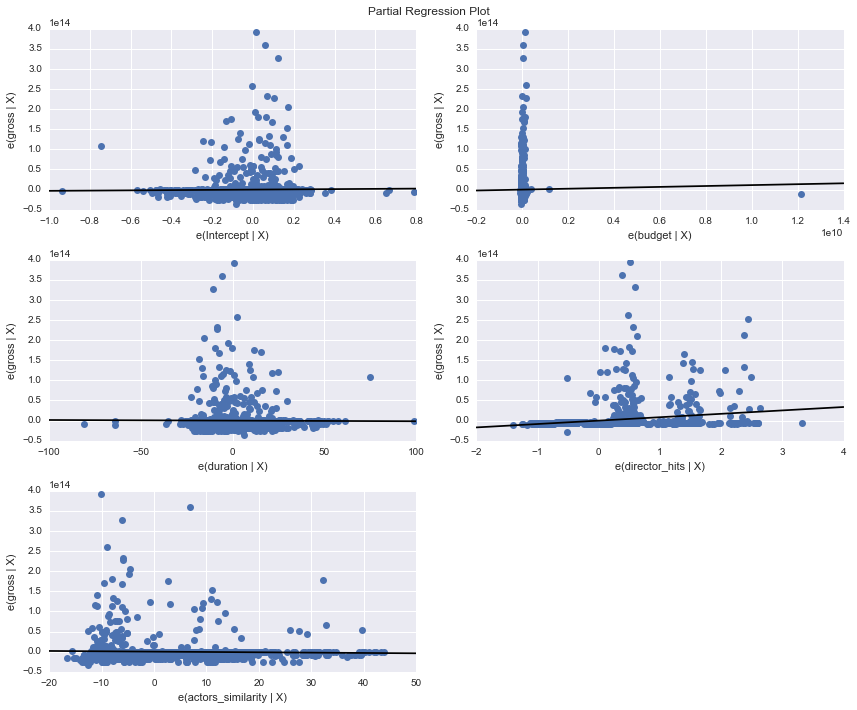

In [66]:
print('Results for ' + top_genres[3] + ' Movies')
ols(movies[3], 'duration', 'director_hits', 'budget') 

Results for Romance Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     16.43
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           4.55e-13
Time:                        20:38:07   Log-Likelihood:                -33543.
No. Observations:                1056   AIC:                         6.710e+04
Df Residuals:                    1051   BIC:                         6.712e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept  

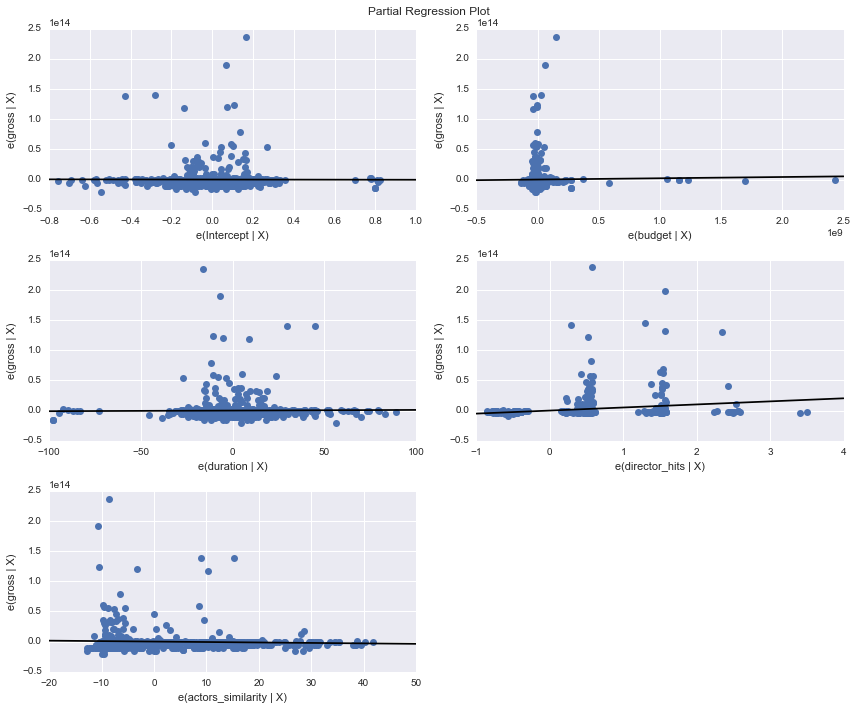

In [67]:
print('Results for ' + top_genres[4] + ' Movies')
ols(movies[4], 'duration', 'director_hits', 'budget') 

Results for Documentary Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     1.251
Date:                Sat, 10 Dec 2016   Prob (F-statistic):              0.332
Time:                        20:38:27   Log-Likelihood:                -372.70
No. Observations:                  20   AIC:                             755.4
Df Residuals:                      15   BIC:                             760.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Interce

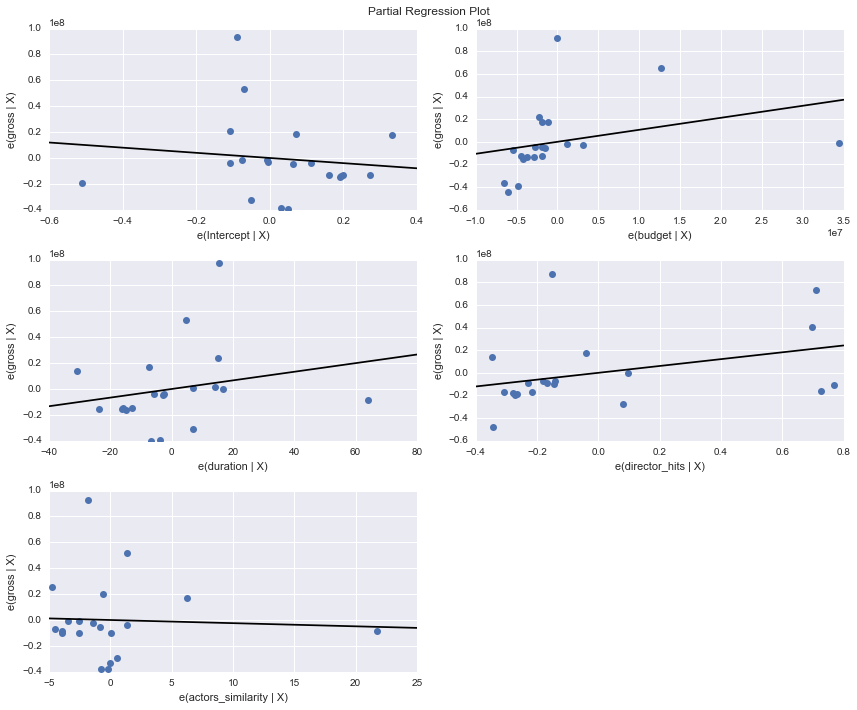

In [68]:
print('Results for ' + unpopular_genres[0] + ' Movies')
ols(movies[5], 'duration', 'director_hits', 'budget') 

Results for Musical Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     2.451
Date:                Sat, 10 Dec 2016   Prob (F-statistic):             0.0507
Time:                        20:38:32   Log-Likelihood:                -3585.7
No. Observations:                 109   AIC:                             7181.
Df Residuals:                     104   BIC:                             7195.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept  

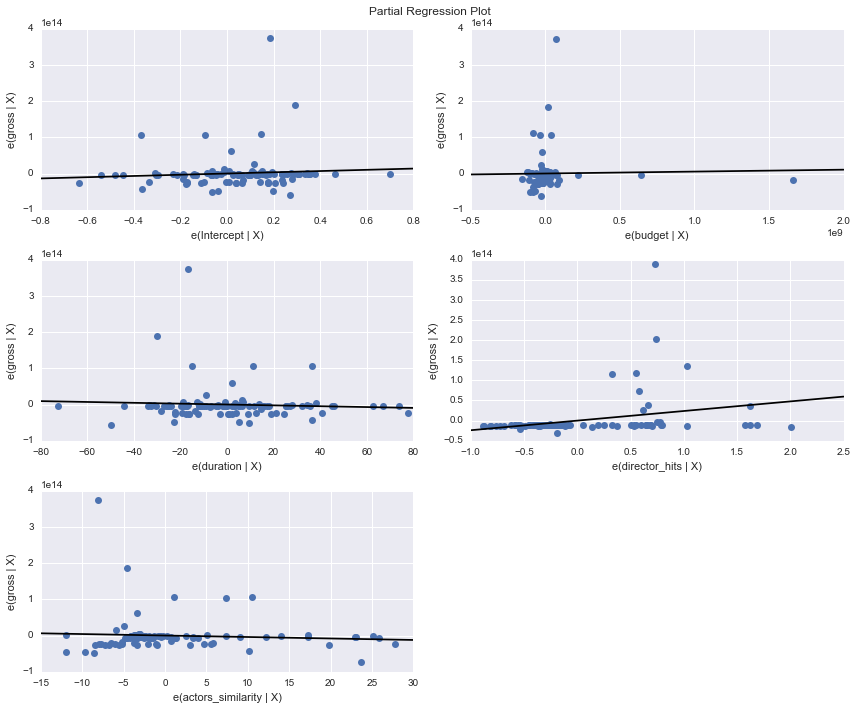

In [69]:
print('Results for ' + unpopular_genres[1] + ' Movies')
ols(movies[6], 'duration', 'director_hits', 'budget') 

Results for History Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2.429
Date:                Sat, 10 Dec 2016   Prob (F-statistic):             0.0492
Time:                        20:38:41   Log-Likelihood:                -6510.8
No. Observations:                 199   AIC:                         1.303e+04
Df Residuals:                     194   BIC:                         1.305e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept  

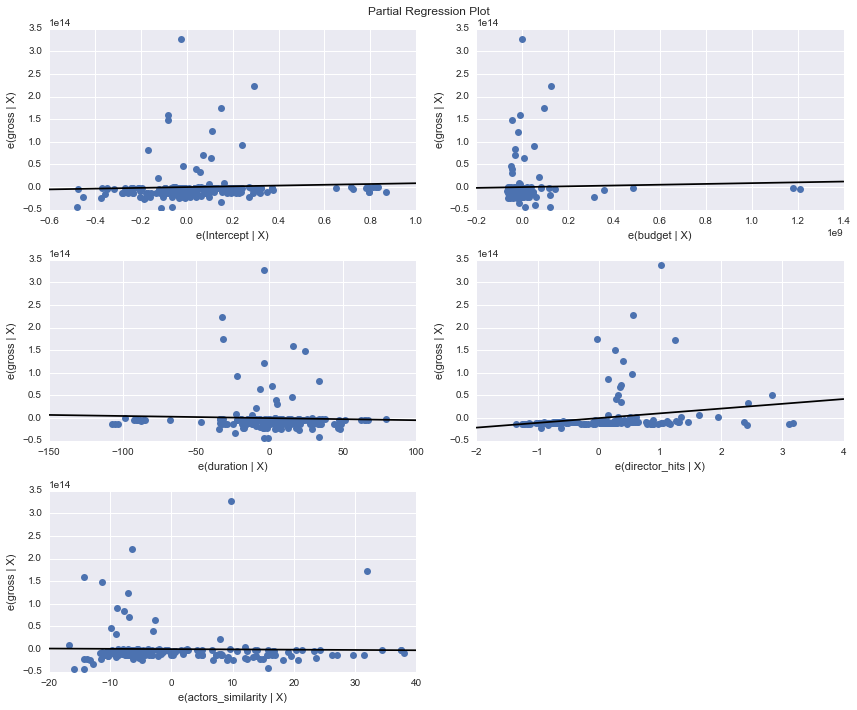

In [70]:
print('Results for ' + unpopular_genres[2] + ' Movies')
ols(movies[7], 'duration', 'title_len', 'budget')